In [17]:
import torch.nn as nn
import torch
from torchvision import models
from datasets.linemod.dataset import DepthDataset
import torch
import os
import torch.nn.functional as F
from lib.loss_depth import LogL2, GradientLoss, NormalLoss
from torch import optim
import numpy as np
import time
import matplotlib.pyplot as plt
from lib.utils import setup_logger, im_convert, depth_to_img
from lib.network import DepthV2
from lib.utils import visualize
from lib.fill_depth_colorization import fill_depth_colorization
from PIL import Image
import png

%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore") 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
mode = 'test'
root = "./datasets/linemod/Linemod_preprocessed"

./datasets/linemod/Linemod_preprocessed/data/06/depth/0891.png ./datasets/linemod/Linemod_preprocessed/data/06/depth_filled/0891
76.0 %
./datasets/linemod/Linemod_preprocessed/data/06/depth/0901.png ./datasets/linemod/Linemod_preprocessed/data/06/depth_filled/0901
./datasets/linemod/Linemod_preprocessed/data/06/depth/0911.png ./datasets/linemod/Linemod_preprocessed/data/06/depth_filled/0911
78.0 %
./datasets/linemod/Linemod_preprocessed/data/06/depth/0923.png ./datasets/linemod/Linemod_preprocessed/data/06/depth_filled/0923
./datasets/linemod/Linemod_preprocessed/data/06/depth/0937.png ./datasets/linemod/Linemod_preprocessed/data/06/depth_filled/0937
80.0 %
./datasets/linemod/Linemod_preprocessed/data/06/depth/0949.png ./datasets/linemod/Linemod_preprocessed/data/06/depth_filled/0949
./datasets/linemod/Linemod_preprocessed/data/06/depth/0959.png ./datasets/linemod/Linemod_preprocessed/data/06/depth_filled/0959
82.0 %
./datasets/linemod/Linemod_preprocessed/data/06/depth/0971.png ./data

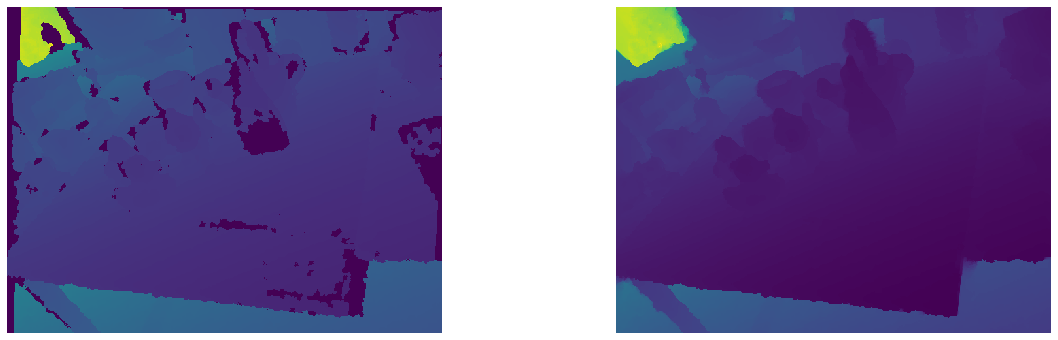

./datasets/linemod/Linemod_preprocessed/data/08/
./datasets/linemod/Linemod_preprocessed/data/08/depth/0012.png ./datasets/linemod/Linemod_preprocessed/data/08/depth_filled/0012
./datasets/linemod/Linemod_preprocessed/data/08/depth/0022.png ./datasets/linemod/Linemod_preprocessed/data/08/depth_filled/0022
2.0 %
./datasets/linemod/Linemod_preprocessed/data/08/depth/0033.png ./datasets/linemod/Linemod_preprocessed/data/08/depth_filled/0033
./datasets/linemod/Linemod_preprocessed/data/08/depth/0047.png ./datasets/linemod/Linemod_preprocessed/data/08/depth_filled/0047
4.0 %
./datasets/linemod/Linemod_preprocessed/data/08/depth/0058.png ./datasets/linemod/Linemod_preprocessed/data/08/depth_filled/0058
./datasets/linemod/Linemod_preprocessed/data/08/depth/0071.png ./datasets/linemod/Linemod_preprocessed/data/08/depth_filled/0071
6.0 %
./datasets/linemod/Linemod_preprocessed/data/08/depth/0083.png ./datasets/linemod/Linemod_preprocessed/data/08/depth_filled/0083
./datasets/linemod/Linemod_pre

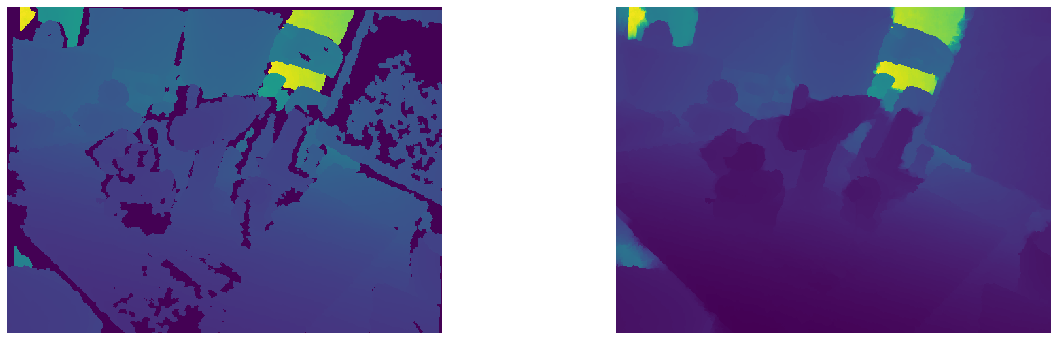

./datasets/linemod/Linemod_preprocessed/data/08/depth/0603.png ./datasets/linemod/Linemod_preprocessed/data/08/depth_filled/0603
./datasets/linemod/Linemod_preprocessed/data/08/depth/0614.png ./datasets/linemod/Linemod_preprocessed/data/08/depth_filled/0614
52.0 %
./datasets/linemod/Linemod_preprocessed/data/08/depth/0626.png ./datasets/linemod/Linemod_preprocessed/data/08/depth_filled/0626
./datasets/linemod/Linemod_preprocessed/data/08/depth/0638.png ./datasets/linemod/Linemod_preprocessed/data/08/depth_filled/0638
54.0 %
./datasets/linemod/Linemod_preprocessed/data/08/depth/0650.png ./datasets/linemod/Linemod_preprocessed/data/08/depth_filled/0650
./datasets/linemod/Linemod_preprocessed/data/08/depth/0663.png ./datasets/linemod/Linemod_preprocessed/data/08/depth_filled/0663
56.0 %
./datasets/linemod/Linemod_preprocessed/data/08/depth/0675.png ./datasets/linemod/Linemod_preprocessed/data/08/depth_filled/0675
./datasets/linemod/Linemod_preprocessed/data/08/depth/0687.png ./datasets/li

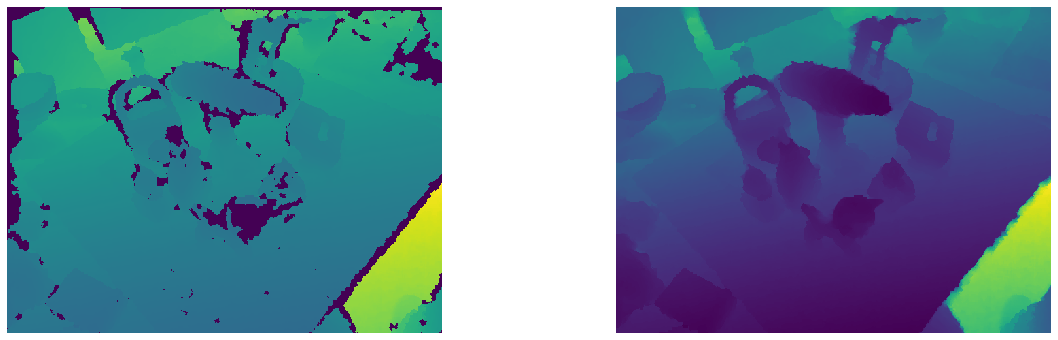

./datasets/linemod/Linemod_preprocessed/data/09/
./datasets/linemod/Linemod_preprocessed/data/09/depth/0010.png ./datasets/linemod/Linemod_preprocessed/data/09/depth_filled/0010
./datasets/linemod/Linemod_preprocessed/data/09/depth/0021.png ./datasets/linemod/Linemod_preprocessed/data/09/depth_filled/0021
1.8867924528301887 %


KeyboardInterrupt: 

In [19]:
objlist = [9, 12, 13, 14, 15]
item_count = 0

for item in objlist:
    files = []
    count = 0
    input_file = open('{0}/data/{1}/test.txt'.format(root, '%02d' % item))
    while 1:
        item_count += 1
        input_line = input_file.readline()
        if mode == 'test' and item_count % 10 != 0:
            continue
        if not input_line:
            break
        if input_line[-1:] == '\n':
            input_line = input_line[:-1]
        files.append(input_line) 

    folder_obj = '{0}/data/{1}/'.format(root, '%02d' % item)
    print(folder_obj)
    base_depth_path = folder_obj + 'depth'
    base_filled_path = folder_obj + 'depth_filled'
    base_rgb_path = folder_obj + 'rgb'
    #     os.mkdir(filled_path)

    for file_name in files:
        depth_path = base_depth_path + '/' + file_name + '.png'
        rgb_img_path = base_rgb_path + '/' + file_name + '.png'
        filled_depth_path = base_filled_path + '/' + file_name

        depth = np.array(Image.open(depth_path))
        rgb = np.array(Image.open(rgb_img_path).convert('RGB'))

        output_depth = fill_depth_colorization(rgb, depth, 1)

        np.save(filled_depth_path, output_depth)
        print(depth_path, filled_depth_path)
        count += 1
        if count % 2 == 0:
            print(count * 100 / len(files), "%")

        if count % 50 == 0:

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
            max_d = np.max(depth)
            min_d = np.min(depth)
            depth_norm = (depth - min_d) * 255 / (max_d - min_d)

            ax1.imshow(depth_norm)
            ax1.axis("off")

            max_d = np.max(output_depth)
            min_d = np.min(output_depth)
            depth_norm = (output_depth - min_d) * 255 / (max_d - min_d)
            ax2.imshow(depth_norm)
            ax2.axis("off")

            plt.show()


In [10]:
len(files)

18

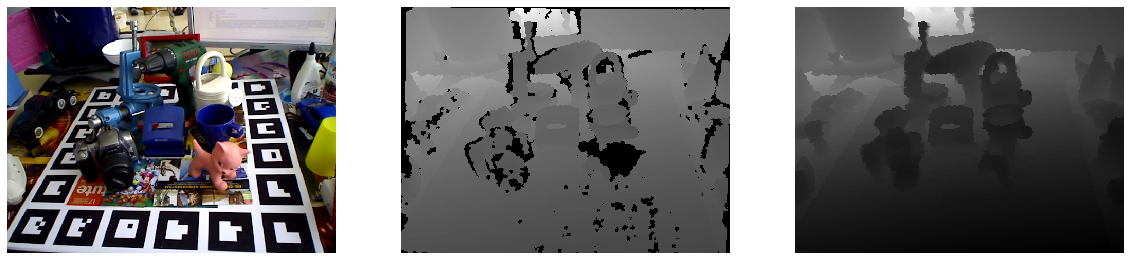

In [24]:
for i, data in enumerate(dataloader, 0):
    img, depth = data
    max_d = torch.max(depth)
    min_d = torch.min(depth)
    depth_norm = (depth - min_d) * 255 / (max_d - min_d)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    ax1.imshow(im_convert(img))
    ax1.axis("off")
    ax2.imshow(depth_to_img(depth_norm), cmap='gray')
    ax2.axis("off")

    output_depth = fill_depth_colorization(img.view(480, 640, 3).numpy(), depth.view(480, 640).numpy(), 1)
    max_d = np.max(output_depth)
    min_d = np.min(output_depth)
    depth_norm = (output_depth - min_d) * 255 / (max_d - min_d)
    
    ax3.imshow(depth_norm, cmap='gray')
    ax3.axis("off")
    plt.show()
    break
        
        

In [ ]:
plt.hist(output_depth.reshape(-1, 1), bins=50);

In [ ]:
plt.hist(depth.reshape(-1, 1), bins=50);

In [7]:
test_iter = iter(testdataloader)

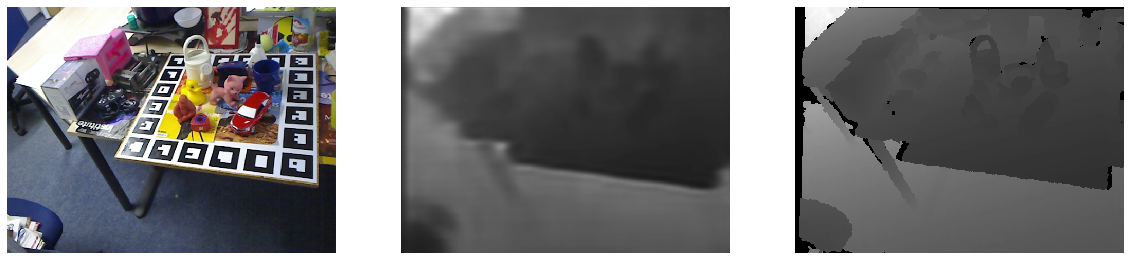

In [9]:
t = next(test_iter)
img, depth = t
img, depth = img.float().cuda(), depth.float().cuda()

model = 'trained_models/depth_prediction/pose_model_15_0.0002779090425557933.pth'
estimator = estimator = DepthV2((480, 640))
estimator.load_state_dict(torch.load(model))
estimator.cuda()
estimator.eval()

pred_log_depth = estimator(img).cpu().detach()[0]
pred_depth = torch.exp(pred_log_depth)
depth = depth.cpu()

visualize(img, depth, pred_depth)

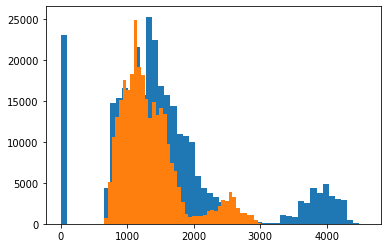

In [104]:
a = depth.cpu().detach().numpy().reshape(-1, 1)
plt.hist(a, bins=50);
b = pred_depth.cpu().detach().numpy().reshape(-1, 1)
plt.hist(b, bins=50);

In [10]:
def im_grad(img):
    fx = torch.tensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]]).view(1, 1, 3, 3).float().cuda()
    fx_conv = nn.Conv2d(1, 1, kernel_size=3, bias=False, padding=1)
    fx_conv.weight = nn.Parameter(fx)

    fy = torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]]).view(1, 1, 3, 3).float().cuda()
    fy_conv = nn.Conv2d(1, 1, kernel_size=3, bias=False, padding=1)
    fy_conv.weight = nn.Parameter(fy)

    img_mean = torch.mean(img, 1, True)
    grad_x = fx_conv(img_mean)
    grad_y = fy_conv(img_mean)
    
    return grad_x, grad_y

In [12]:
depth = depth.view(1, 1, 480, -1).cuda()
pred_depth = pred_depth.view(1, 1, 480, -1).cuda()

In [13]:
mask_depth = depth.eq(0.).view(1, 1, 480, -1).cuda()
pred_depth = torch.exp(pred_log_depth).view(1, 1, 480, -1).cuda()
depth[mask_depth] = np.inf # use the predicted value to fill in the missing values

grad_true_depth_x, grad_true_depth_y = im_grad(depth)
grad_pred_depth_x, grad_pred_depth_y = im_grad(pred_depth)

In [21]:
grad_masked = torch.abs(grad_true_depth_x).eq(np.inf)
grad_true_depth_x[grad_masked] = 0

In [22]:
grad_true_depth_x

tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.5000e+01,
           5.0000e+00, 5.3120e+03],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.0000e+01,
           1.5000e+01, 5.3120e+03],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.5000e+01,
           1.5000e+01, 3.9840e+03]]]], device='cuda:0',
       grad_fn=<IndexPutBackward>)

In [108]:
ones = torch.ones(depth.size(0), 1, depth.size(2),depth.size(3)).float().cuda()
ones = torch.autograd.Variable(ones)

In [109]:
true_depth_normal = torch.cat((-grad_true_depth_x, -grad_true_depth_y, ones), 1)
pred_normal = torch.cat((-grad_pred_depth_x, -grad_pred_depth_y, ones), 1)

In [110]:
true_depth_normal.shape

torch.Size([1, 3, 480, 640])

In [111]:
cos = nn.CosineSimilarity(dim=1, eps=0)
torch.abs(1 - cos(pred_normal, true_depth_normal)).mean()

tensor(0.6385, device='cuda:0', grad_fn=<MeanBackward0>)